# 對 zscore_log2_filtered_* 資料做層次式 clustering，畫出 heatmap

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")

In [2]:
# 建立新的 DataFrame 存放處理結果
import h5py
import numpy as np
import pandas as pd

# -----------------------------------------------------
# Step 1: 讀取 HDF5 中 Train slide 的 spot 資料，並以 slide 名稱建立 DataFrame 字典
# -----------------------------------------------------
with h5py.File("dataset/spots-data/version-4/gu_zscore_processed_train_spots.h5", "r") as f:
    train_spots = f["spots/log2_Train"]
    
    # 建立存放各 slide spot 表格的字典：train_spot_tables
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # 從 HDF5 讀取資料並轉換成 NumPy array，再轉換成 DataFrame
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        # 加入 slide_name 欄位，用以日後依照 slide 分組儲存
        df["slide_name"] = slide_name
        train_spot_tables[slide_name] = df
        print(f"已讀取 slide: {slide_name}")


# ------------------------------
# Step 2: 合併所有 slide 資料，並取得 cell type 欄位 (例如：以 "C" 起始)
# ------------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)
filtered_df = all_train_spots_df.copy()

已讀取 slide: S_1
已讀取 slide: S_2
已讀取 slide: S_3
已讀取 slide: S_4
已讀取 slide: S_5
已讀取 slide: S_6


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
cell_type_cols = [col for col in filtered_df.columns if col.startswith("zscore_log2_filtered_")]

# 取得 z-score 標準化後的欄位
zscore_cols = [col for col in cell_type_cols]

# 只取這些欄位資料
clust_data = filtered_df[zscore_cols]

# 把欄位名稱簡化成 cell type（去掉前綴）
clust_data.columns = cell_type_cols


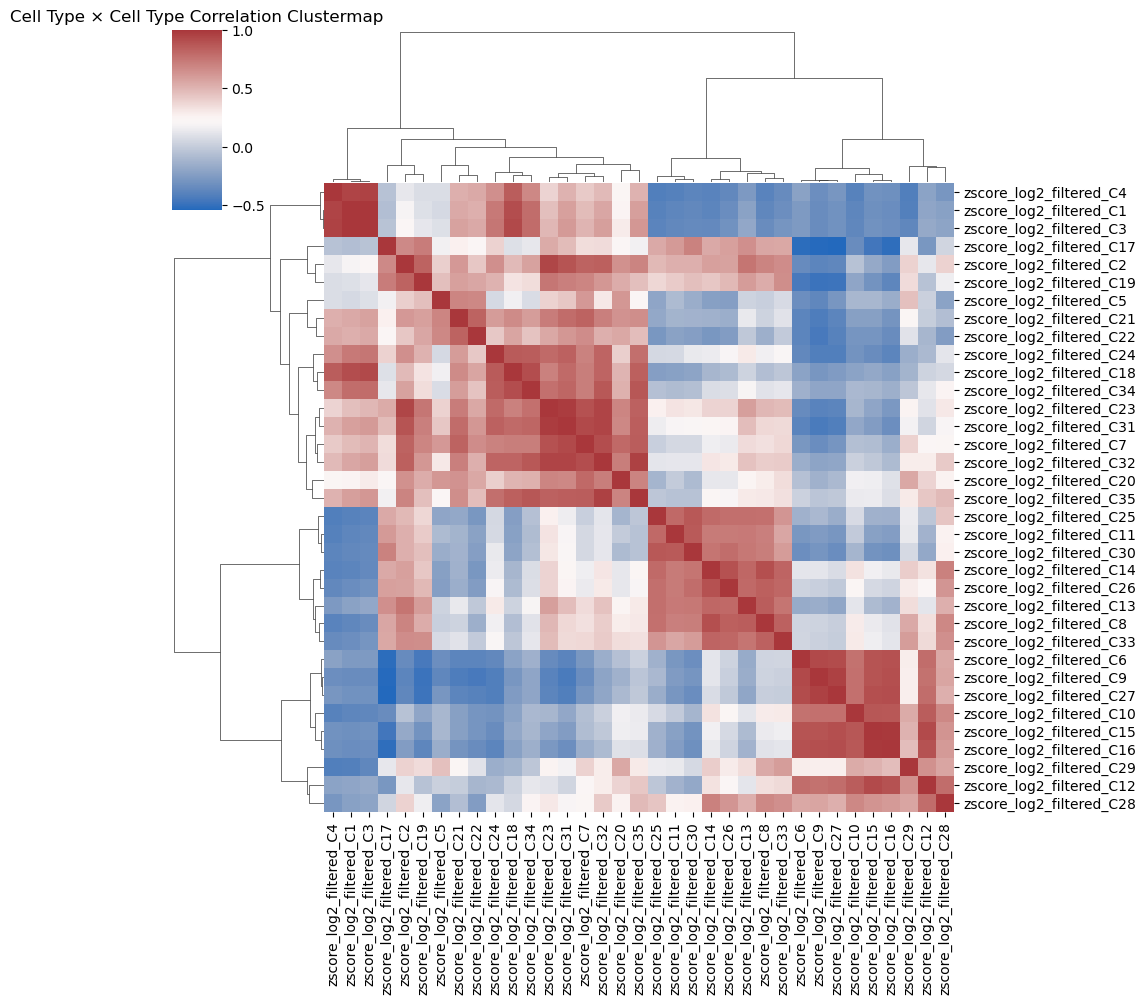

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# 原始資料：filtered_df[zscore_cols] 是 samples × cell types，我們要做 corr → cell × cell
zscore_data = filtered_df[zscore_cols]

# 把欄位名稱簡化（optional，讓圖比較乾淨）
zscore_data.columns = cell_type_cols

# 計算相關矩陣（cell types × cell types）
corr_matrix = zscore_data.corr(method='pearson')  # or 'spearman' if non-normal

# 畫出 correlation heatmap + clustering
sns.clustermap(
    corr_matrix,
    method='ward',      # clustering 方法：ward / average / complete / single
    metric='euclidean', # 或用 'correlation' 做距離
    cmap='vlag',        # 紅藍色調
    figsize=(10, 10),
    annot=False         # 要不要在格子裡寫數字
)
plt.title("Cell Type × Cell Type Correlation Clustermap")
plt.show()


# AE choose latent size

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# 1. 取得特徵欄位
zscore_cols = ["zscore_log2_filtered_" + col for col in cell_type_cols]
X = filtered_df[zscore_cols].values.astype(np.float32)

# 2. Train-test split
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)


cpu

▶ Training AE with latent_dim = 10
  val_loss: 0.2402 | mean corr: 0.8583

▶ Training AE with latent_dim = 11
  val_loss: 0.2303 | mean corr: 0.8642

▶ Training AE with latent_dim = 12
  val_loss: 0.2221 | mean corr: 0.8688

▶ Training AE with latent_dim = 15
  val_loss: 0.1913 | mean corr: 0.8860

▶ Training AE with latent_dim = 16
  val_loss: 0.1591 | mean corr: 0.9073

▶ Training AE with latent_dim = 17
  val_loss: 0.1692 | mean corr: 0.9009


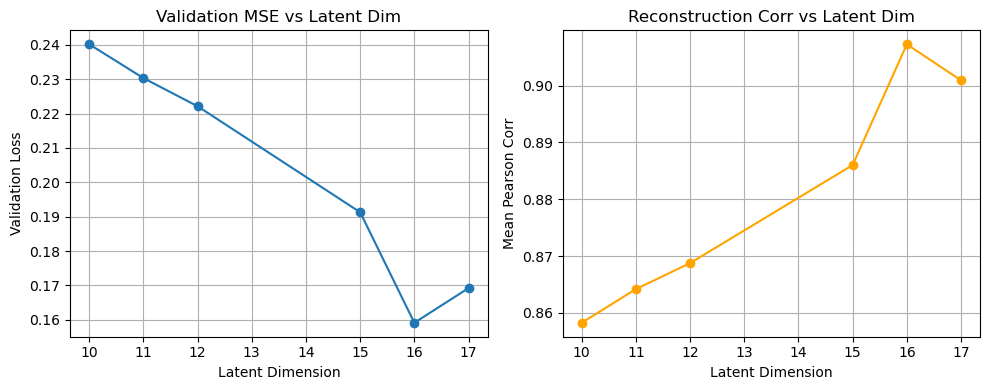

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
latent_dims = [10, 11, 12, 15, 16,17]
val_losses = []
mean_corrs = []
latent_corrs = []

X_tensor = torch.tensor(X, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor), batch_size=32, shuffle=False)

# 定義 Autoencoder 結構
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 24),
            nn.LeakyReLU(0.1),
            nn.Linear(24, 20),
            nn.LeakyReLU(0.1),
            nn.Linear(20, latent_dim),
            nn.LeakyReLU(0.1)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 20),
            nn.LeakyReLU(0.1),
            nn.Linear(20, 24),
            nn.LeakyReLU(0.1),
            nn.Linear(24, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

# 開始 sweep
for dim in latent_dims:
    print(f"\n▶ Training AE with latent_dim = {dim}")

    model = Autoencoder(input_dim=X.shape[1], latent_dim=dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # 訓練
    model.train()
    for epoch in range(200):
        for (batch,) in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon, _ = model(batch)
            loss = criterion(recon, batch)
            loss.backward()
            optimizer.step()

    # 驗證 loss
    model.eval()
    with torch.no_grad():
        val_recon, _ = model(X_val_tensor.to(device))
        val_loss = criterion(val_recon, X_val_tensor.to(device)).item()
        val_losses.append(val_loss)

        # 全體重建
        full_recon, latent = model(X_tensor.to(device))
        X_recon_np = full_recon.cpu().numpy()
        latent_np = latent.cpu().numpy()

        # 平均 correlation（逐筆 Pearson）
        corrs = [pearsonr(X[i], X_recon_np[i])[0] for i in range(X.shape[0])]
        mean_corr = np.mean(corrs)
        mean_corrs.append(mean_corr)

        # latent correlation matrix
        corr_matrix = pd.DataFrame(latent_np).corr()
        latent_corrs.append(corr_matrix)

    print(f"  val_loss: {val_loss:.4f} | mean corr: {mean_corr:.4f}")
    
# Loss & corr plot
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.plot(latent_dims, val_losses, marker='o')
plt.title("Validation MSE vs Latent Dim")
plt.xlabel("Latent Dimension")
plt.ylabel("Validation Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(latent_dims, mean_corrs, marker='o', color='orange')
plt.title("Reconstruction Corr vs Latent Dim")
plt.xlabel("Latent Dimension")
plt.ylabel("Mean Pearson Corr")
plt.grid(True)

plt.tight_layout()
plt.show()



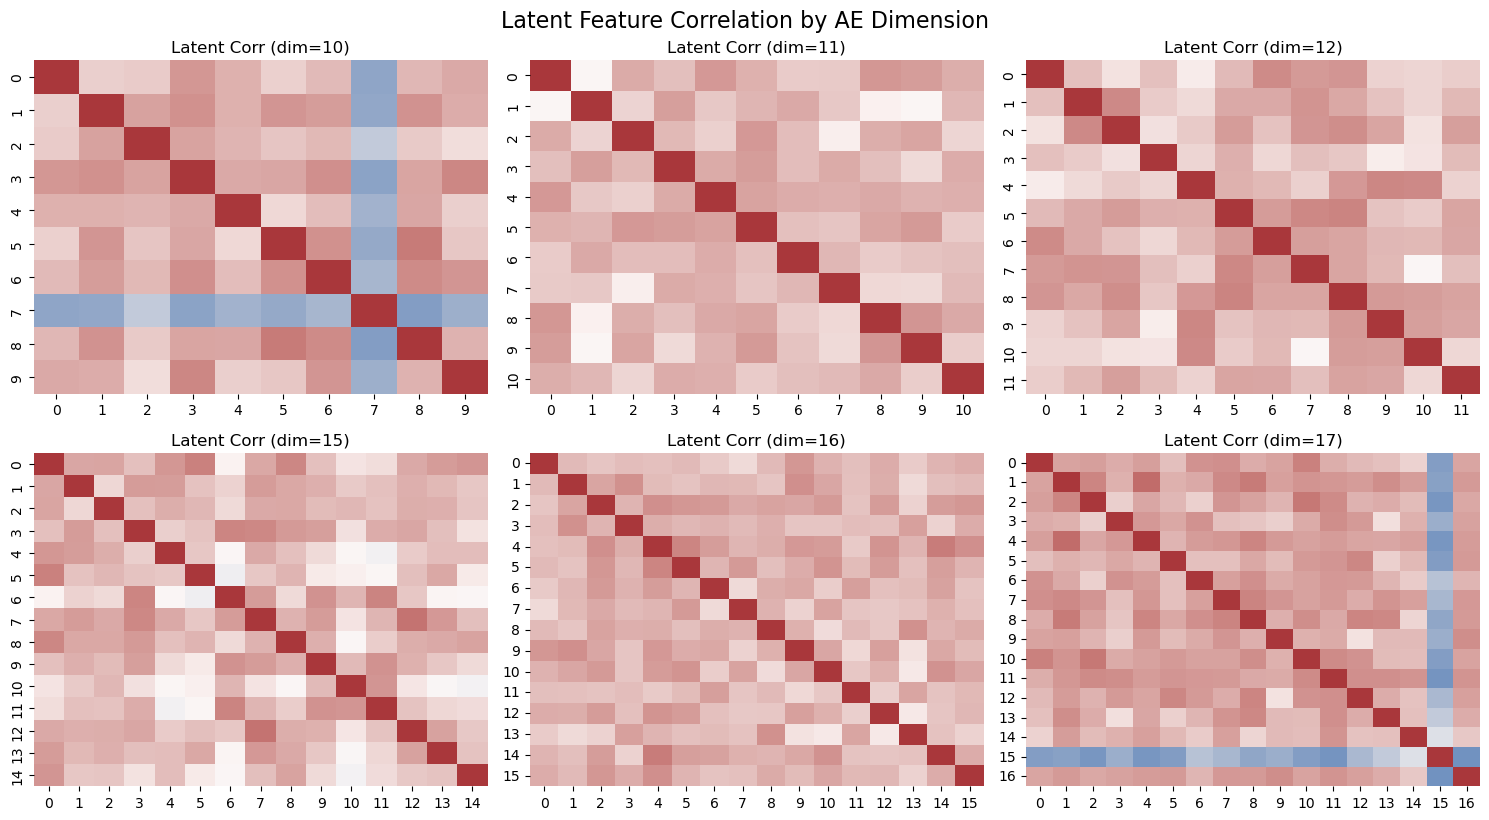

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 設定子圖排列
n = len(latent_dims)
ncols = 3
nrows = (n // ncols) + int(n % ncols > 0)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))

for i, dim in enumerate(latent_dims):
    ax = axes.flatten()[i]
    corr_matrix = latent_corrs[i]
    sns.heatmap(corr_matrix, cmap='vlag', center=0, ax=ax, cbar=False)
    ax.set_title(f"Latent Corr (dim={dim})")

# 清除多餘的空白子圖
for j in range(i+1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.suptitle("Latent Feature Correlation by AE Dimension", fontsize=16, y=1.02)
plt.show()


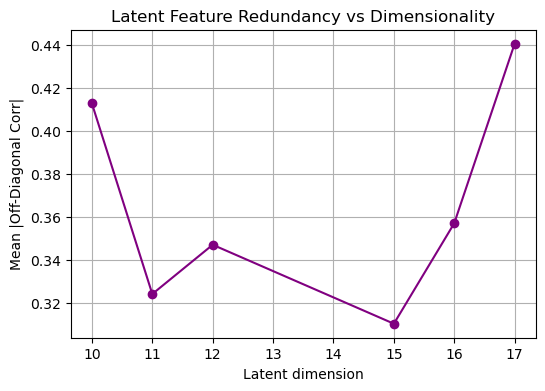

✅ 最 decorrelated 的 latent_dim 是 15（Mean |corr| = 0.3104）


In [ ]:
def mean_off_diagonal_abs_corr(corr_matrix):
    # 移除對角線
    mask = ~np.eye(corr_matrix.shape[0], dtype=bool)
    off_diag_values = corr_matrix.values[mask]
    return np.mean(np.abs(off_diag_values))

# 計算每個 latent 維度下的平均共線性
mean_corrs = [mean_off_diagonal_abs_corr(c) for c in latent_corrs]
plt.figure(figsize=(6,4))
plt.plot(latent_dims, mean_corrs, marker='o', color='purple')
plt.xlabel("Latent dimension")
plt.ylabel("Mean |Off-Diagonal Corr|")
plt.title("Latent Feature Redundancy vs Dimensionality")
plt.grid(True)
plt.show()
best_idx = np.argmin(mean_corrs)
best_dim = latent_dims[best_idx]

print(f"✅ 最 decorrelated 的 latent_dim 是 {best_dim}（Mean |corr| = {mean_corrs[best_idx]:.4f}）")


訓練 log 已儲存至 AE_15_2layer/training_log.csv
Epoch [234/500]  val_loss: 0.1689, mean_corr: 0.9019


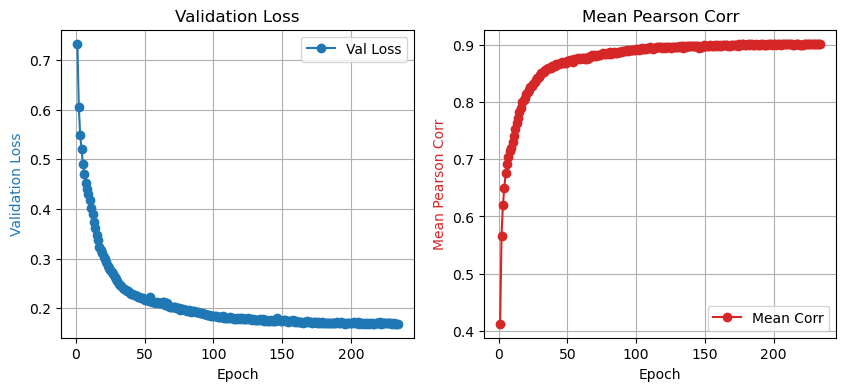

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from IPython.display import clear_output

# ---------------------------
# 設定資料夾與資料
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_folder = "AE_15_2layer"  # 請自行修改為你想儲存的資料夾路徑
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# 假設這裡已有資料，以下僅以隨機資料作範例


# ---------------------------
# 設定裝置與參數
# ---------------------------
latent_dim = 15  # 固定 latent_dim 為 15

# ---------------------------
# 轉換資料成 tensor 與建立 DataLoader
# ---------------------------
X_tensor = torch.tensor(X, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor), batch_size=32, shuffle=False)

# ---------------------------
# 定義 Autoencoder 模型結構
# ---------------------------


# ---------------------------
# 建立模型、optimizer 與 loss function
# ---------------------------
model = Autoencoder(input_dim=X.shape[1], latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

#---------------------------
# 訓練 log 記錄
#---------------------------
training_log = {"epoch": [], "val_loss": [], "mean_corr": []}

num_epochs = 500
best_val_loss = float('inf')
best_model_state = None

#---------------------------
# 設定動態圖形（雙 y 軸）
#---------------------------
best_model_path = os.path.join(save_folder, "best_autoencoder.pt")
training_log_path = os.path.join(save_folder, "training_log.csv")

# 建立一個 figure，有兩個子圖，排列方式為一個 column（兩列一欄）

#---------------------------
# 開始訓練
#---------------------------
for epoch in range(1, num_epochs+1):
    # 訓練階段
    clear_output(wait=True)
    model.train()
    for (batch,) in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon, _ = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()
    
    # 驗證階段：計算驗證 loss（用 X_val 整批資料計算）
    model.eval()
    with torch.no_grad():
        val_recon, _ = model(X_val_tensor.to(device))
        val_loss = criterion(val_recon, X_val_tensor.to(device)).item()
    
    # 全體資料重建，計算平均 Pearson correlation（逐筆計算，再取平均）
    with torch.no_grad():
        full_recon, _ = model(X_tensor.to(device))
    X_recon_np = full_recon.cpu().numpy()
    corrs = [pearsonr(X[i], X_recon_np[i])[0] for i in range(X.shape[0])]
    mean_corr = np.mean(corrs)
    
    # 更新 log
    training_log["epoch"].append(epoch)
    training_log["val_loss"].append(val_loss)
    training_log["mean_corr"].append(mean_corr)
    log_df = pd.DataFrame(training_log)
    log_df.to_csv(training_log_path, index=False)
    print(f"訓練 log 已儲存至 {training_log_path}")
    
    # 儲存表現最好的模型（以驗證 loss 最低為準）
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        torch.save(model.state_dict(), best_model_path)
        print(f"模型權重已儲存至 {best_model_path}")
    
    print(f"Epoch [{epoch}/{num_epochs}]  val_loss: {val_loss:.4f}, mean_corr: {mean_corr:.4f}")
    
    # 利用 clear_output 清除前次輸出，再繪製新的圖形
    
    # 建立一個 figure，有兩個子圖，排列方式為一個 column（兩列一欄）
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    
    # 繪製 Validation Loss 子圖
    ax1.plot(training_log["epoch"], training_log["val_loss"], marker='o', color="tab:blue", label="Val Loss")
    ax1.set_title("Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Validation Loss", color="tab:blue")
    ax1.grid(True)
    ax1.legend()
    
    # 繪製 Mean Pearson Corr 子圖
    ax2.plot(training_log["epoch"], training_log["mean_corr"], marker='o', color="tab:red", label="Mean Corr")
    ax2.set_title("Mean Pearson Corr")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Mean Pearson Corr", color="tab:red")
    ax2.grid(True)
    ax2.legend()
    
    # 顯示整體圖形
    plt.show()
# 訓練結束後，可關閉互動模式並儲存最終圖形
plt.ioff()
loss_plot_path = os.path.join(save_folder, "loss_curve.png")
fig.savefig(loss_plot_path)
plt.close(fig)
print(f"訓練結束，loss 曲線圖已儲存至 {loss_plot_path}")

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_91002/733145709.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_p

最終驗證 loss: 0.2156
平均 Pearson correlation: 0.8699
Mean off-diagonal abs corr: 0.2745

結果已儲存至 AE_17/result.txt


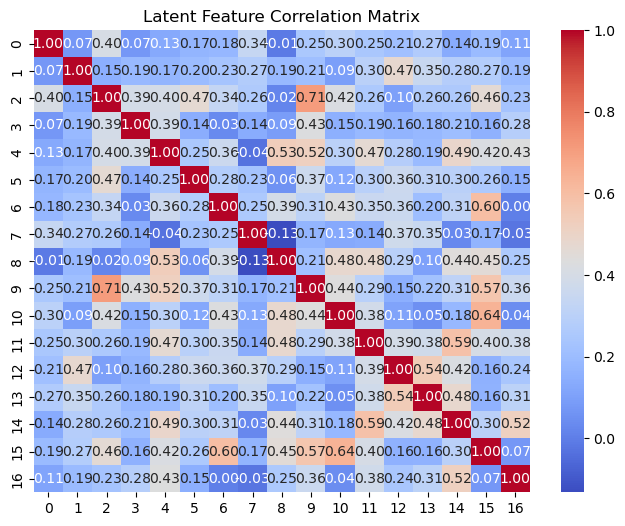

In [ ]:
import seaborn as sns

# 定義計算 off-diagonal 絕對值平均相關係數的函式
def mean_off_diagonal_abs_corr(corr_matrix):
    # 利用 numpy.eye 產生對角線遮罩，再選出非對角線的數值
    mask = ~np.eye(corr_matrix.shape[0], dtype=bool)
    off_diag_values = corr_matrix.values[mask]
    return np.mean(np.abs(off_diag_values))
result_txt_path = os.path.join(save_folder, "result.txt")

# ---------------------------
# 驗證模型在整個資料集上的表現
# ---------------------------
model.load_state_dict(torch.load(best_model_path))
model.eval()
with torch.no_grad():
    # 驗證集表現
    val_recon, _ = model(X_val_tensor.to(device))
    final_val_loss = criterion(val_recon, X_val_tensor.to(device)).item()
    
    # 全資料重建與 latent representation
    full_recon, latent_out = model(X_tensor.to(device))
    X_recon_np = full_recon.cpu().numpy()
    latent_np = latent_out.cpu().numpy()
    
    # 每筆資料的 Pearson correlation
    corrs = [pearsonr(X[i], X_recon_np[i])[0] for i in range(X.shape[0])]
    mean_corr = np.mean(corrs)
    
    # 計算 latent features 的 correlation matrix 並印出 heatmap
    corr_matrix = pd.DataFrame(latent_np).corr()
    mean_off_diag_corr = np.mean(np.abs(corr_matrix.values[~np.eye(corr_matrix.shape[0], dtype=bool)]))
    
    # 將結果整理成字串
    result_str = (
        f"最終驗證 loss: {final_val_loss:.4f}\n"
        f"平均 Pearson correlation: {mean_corr:.4f}\n"
        f"Mean off-diagonal abs corr: {mean_off_diag_corr:.4f}\n"
    )
    
    print(result_str)
    
    # 將結果存入 txt 檔
    with open(result_txt_path, "w") as f:
        f.write(result_str)
    print(f"結果已儲存至 {result_txt_path}")
    
    # 繪製 heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Latent Feature Correlation Matrix")
    plt.show()

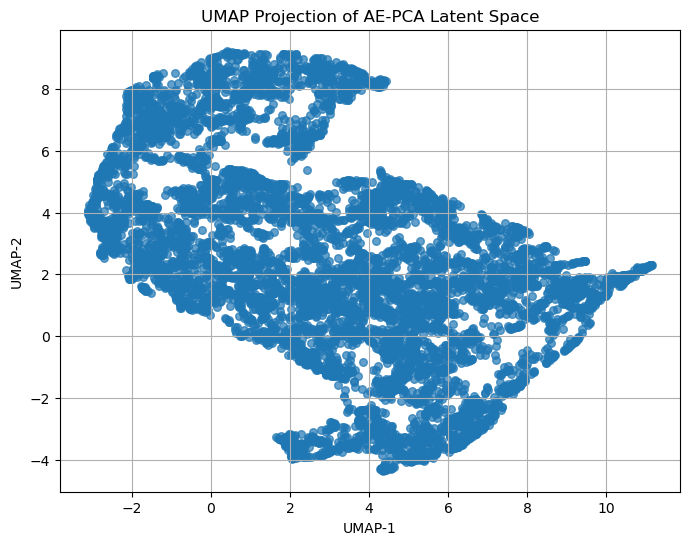

In [ ]:

# scatter plot 畫出樣本分佈
plt.figure(figsize=(8,6))
plt.scatter(embedding[:, 0], embedding[:, 1], s=30, alpha=0.7)
plt.title("UMAP Projection of AE-PCA Latent Space")
plt.xlabel("UMAP-1")best_latent_dim = latent_dims[best_idx]
print(f"Best latent_dim: {best_latent_dim}")
best_latent_dim = latent_dims[best_idx]
print(f"Best latent_dim: {best_latent_dim}")

# 使用最佳 latent_dim 重新訓練模型（或你也可以在 sweep 的時候順便儲存最佳模型）
best_model = Autoencoder(input_dim=X.shape[1], latent_dim=best_latent_dim).to(device)
optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 重新訓練
best_model.train()
for epoch in range(200):
    for (batch,) in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon, _ = best_model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()

# 儲存模型權重到檔案
torch.save(best_model.state_dict(), "best_autoencoder.pt")
print("Model weights saved to best_autoencoder.pt")# 使用最佳 latent_dim 重新訓練模型（或你也可以在 sweep 的時候順便儲存最佳模型）
best_model = Autoencoder(input_dim=X.shape[1], latent_dim=best_latent_dim).to(device)
optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 重新訓練
best_model.train()
for epoch in range(200):
    for (batch,) in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon, _ = best_model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()

# 儲存模型權重到檔案
torch.save(best_model.state_dict(), "best_autoencoder.pt")
print("Model weights saved to best_autoencoder.pt")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()
